# Control theory and Vicsek Model - Clustering data

# Import libraries

In [38]:
# General imports
import numpy as np # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
from sklearn import cluster
from IPython.display import Video, display

In [39]:
# Module imports
sys.path.append('..')
import models.vicsek as vicsek
import visualisation as visualisation
import utils

In [40]:
# set the random seed
np.random.seed(0)

# Launching a simulation 

In [41]:
# Initialize the Vicsek model.
radius = 2
L = 50
N = 300


In [5]:
simulator = vicsek.Vicsek(numberOfParticles=N, domainSize=(L, L), radius=radius)
# Simulate the Vicsek model.
simulationData = simulator.simulate()

# Extract the simulation data.
# time, positions, orientations = simulationData[0], simulationData[1], simulationData[2]

In [6]:
df = utils.simulationDataToDataframe(simulationData)
df.head()

,t,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,theta_x_295,theta_y_295,theta_x_296,theta_y_296,theta_x_297,theta_y_297,theta_x_298,theta_y_298,theta_x_299,theta_y_299
0,0.0,26.998653,35.525766,30.328990,26.782004,21.672221,32.192685,21.561002,44.203102,48.237752,...,0.859463,0.511197,-0.625989,0.779832,-0.889528,-0.456880,0.971440,-0.237283,0.997567,0.069707
1,0.5,26.575922,35.258749,30.037450,26.375796,22.075042,32.488887,21.061287,44.186199,48.250015,...,0.396766,0.917920,-0.097389,0.995246,-0.804150,-0.594426,0.239907,-0.970796,0.616877,0.787059
2,1.0,26.238041,34.890190,30.067247,25.876685,22.212369,32.969658,20.562835,44.146888,48.244105,...,0.382330,0.924026,-0.427237,0.904140,-0.938130,-0.346284,0.588750,-0.808315,0.618284,0.785955
3,1.5,25.792601,34.663070,29.935506,25.394353,22.006171,33.425161,20.096035,43.967729,47.748631,...,0.280959,0.959720,-0.400137,0.916456,-0.986072,-0.166318,0.422848,-0.906200,0.795974,0.605331
4,2.0,25.314897,34.515423,29.502672,25.144044,21.813587,33.886584,19.705695,43.655263,47.251283,...,0.463349,0.886176,-0.429421,0.903104,-0.979027,-0.203731,0.467956,-0.883752,0.776847,0.629690


In [7]:
# # Initialize the Matplotanimator and feed the simulation data and domain size.
# animator = MatplotlibAnimator.MatplotlibAnimator(simulationData, (50,50))
# # Prepare the animator for a 2D representation.
# preparedAnimator = animator.prepare(Animator2D.Animator2D())
# preparedAnimator.saveAnimation('data/vicsek_test.mp4')

In [8]:
# display(Video('data/vicsek_test.mp4', embed=False))

# Clustering analysis

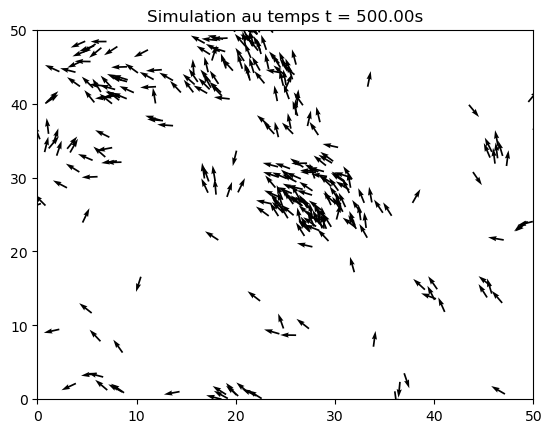

In [9]:
fig, ax = visualisation.plot_simulation(df, 1000, L)
plt.show()

## Clustering scaled data without periodic conditions 

In [10]:
### TESTS
pos_labels = utils.naive_clustering_labels_positions(df, -1)
orient_labels = utils.naive_clustering_labels_orientations(df, -1)
all_labels = utils.naive_clustering_labels_positions_and_orientations(df, -1)

for label, text in zip([pos_labels, orient_labels, all_labels], ["positions", "orientations", "positions and orientations"]):
    n_clust, n_noise = utils.clustering_labels_stats(label)
    print(f"{text}: Number of clusters: {n_clust}, number of noise points: {n_noise}")


positions: Number of clusters: 7, number of noise points: 34
orientations: Number of clusters: 3, number of noise points: 0
positions and orientations: Number of clusters: 6, number of noise points: 170


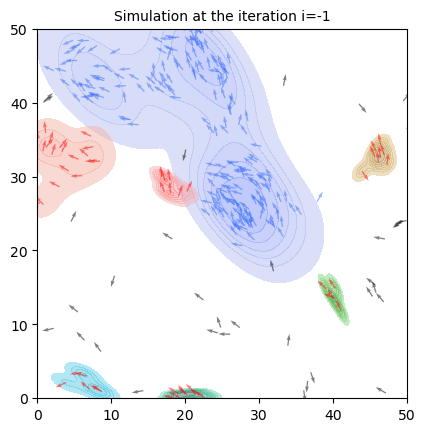

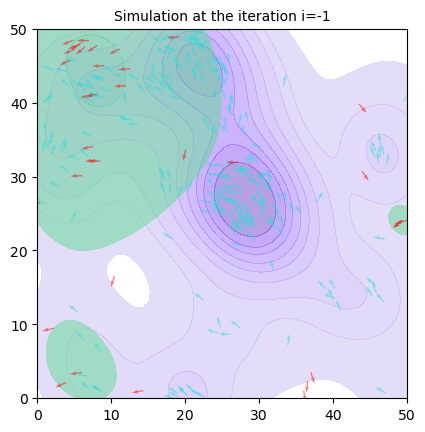

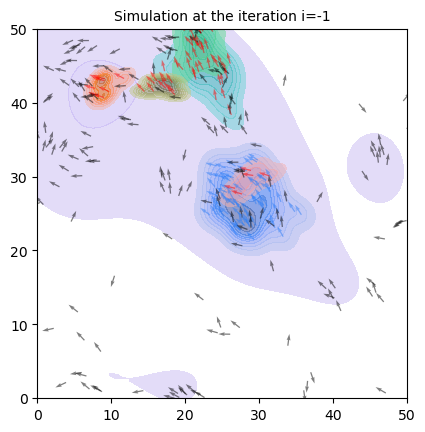

In [11]:
fig, ax = visualisation.plot_clusters(df, -1, pos_labels)
fig, ax = visualisation.plot_clusters(df, -1, orient_labels)
fig, ax = visualisation.plot_clusters(df, -1, all_labels)

plt.show()

This method is very sensitive to clusters with different densities. This is why it must be calibrated "by hand". We can try to implement a clustering method which uses data that are not scaled. 

## Clustering with unscaled data and without periodic boundaries 

In [12]:
def clustering_labels_positions(df, i, k_coef, rho, min_samples=5):
    df_pos = utils.get_positions(df, i)
    threshold = np.sqrt(min_samples / (np.pi * rho * k_coef))
    db_pos = cluster.DBSCAN(eps=threshold, min_samples=min_samples).fit(df_pos)
    return db_pos.labels_

def clustering_labels_angles(df, i, delta_theta, N, k_coef):
    df_angle = utils.get_angles(df, i)
    min_sample = np.ceil(k_coef * N * delta_theta / (2 * np.pi))
    db_angle = cluster.DBSCAN(eps=delta_theta/2, min_samples=min_sample).fit(df_angle.to_numpy().reshape(-1, 1))
    return db_angle.labels_

def clustering_labels_velocities(df, i, k_coef, N, min_samples=5):
    df_vel = utils.get_orientations(df, i)
    rho = N / 4
    threshold = np.sqrt(min_samples / (np.pi * rho * k_coef))
    db_vel = cluster.DBSCAN(eps=threshold, min_samples=min_samples).fit(df_vel)
    return db_vel.labels_

def clustering_labels_positions_and_orientations(df, i, k_coef, rho, min_samples=5):
    df_all = utils.get_positions_and_angles(df, i)
    threshold = np.sqrt(min_samples / (np.pi * rho * k_coef))
    db_all = cluster.DBSCAN(eps=threshold, min_samples=min_samples).fit(df_all)
    return db_all.labels_

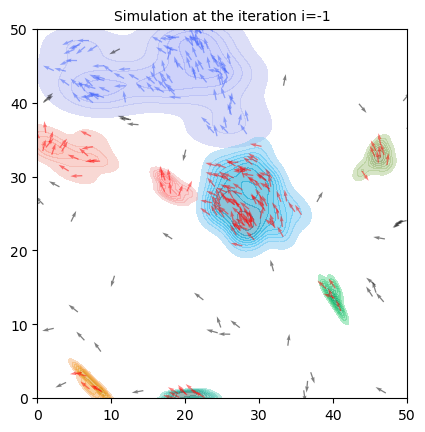

In [13]:
pos_labels = clustering_labels_positions(df, -1, k_coef=2, rho=N/(L**2), min_samples=5)
visualisation.plot_clusters(df, -1, pos_labels)
plt.show()

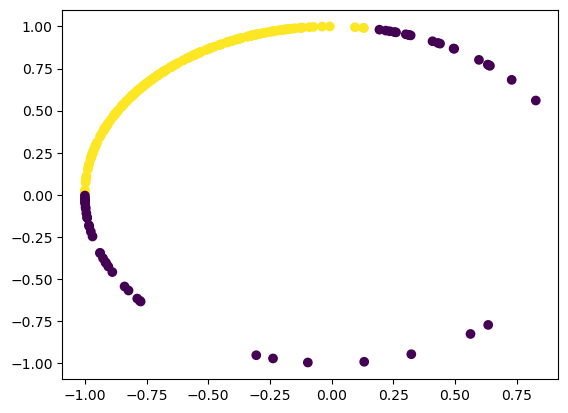

In [14]:
ang_labels = clustering_labels_angles(df, -1, np.pi/6., N, 2)
# fig, ax = visualisation.plot_clusters(df, -1, custom_labels=ang_labels)
df_ang = utils.get_angles(df, -1)
plt.scatter(np.cos(df_ang), np.sin(df_ang), c=ang_labels)
plt.show()

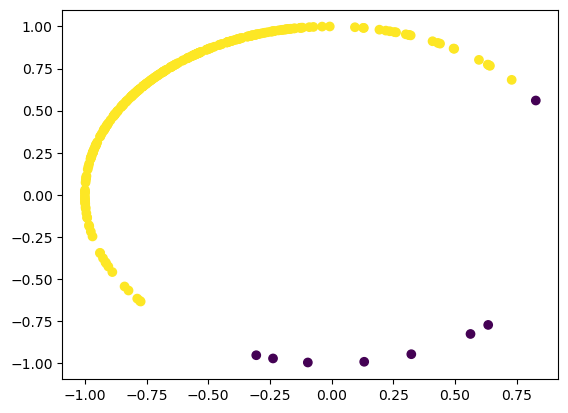

In [15]:
vel_labels = clustering_labels_velocities(df, -1, k_coef = 1, N=N, min_samples=5)
df_ang = utils.get_angles(df, -1)
plt.scatter(np.cos(df_ang), np.sin(df_ang), c=vel_labels)
plt.show()


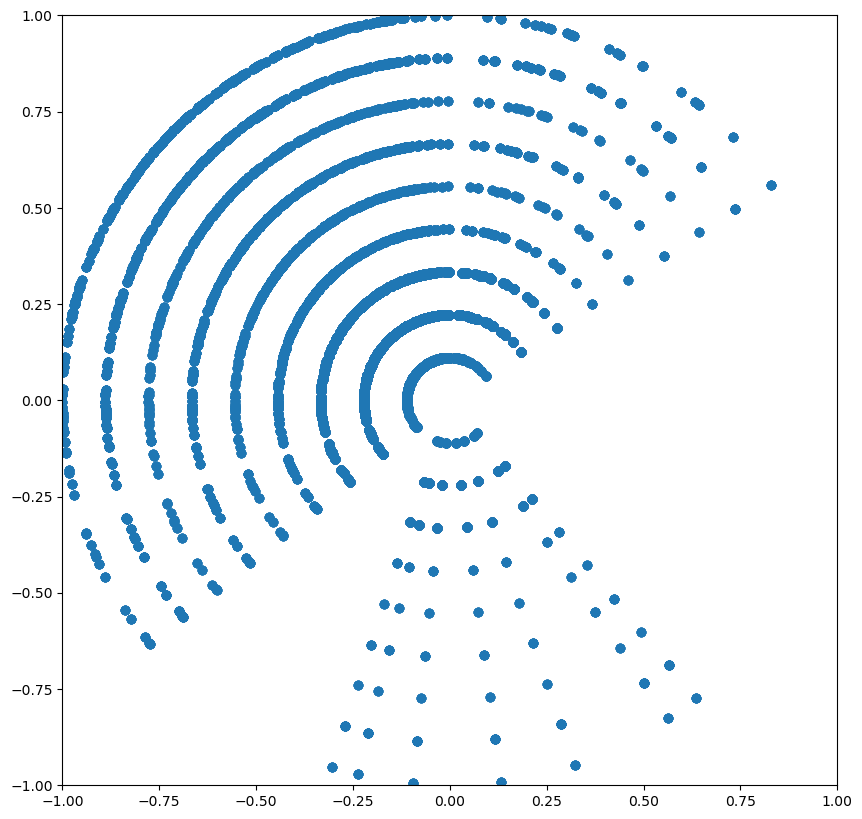

In [16]:
df_ang = utils.get_angles(df, -1)
amp = (pos_labels + 2) / len(np.unique(pos_labels)+1)

plt.figure(figsize=(10, 10))
plt.scatter(amp * np.cos(df_ang.to_numpy()), amp * np.sin(df_ang.to_numpy()))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

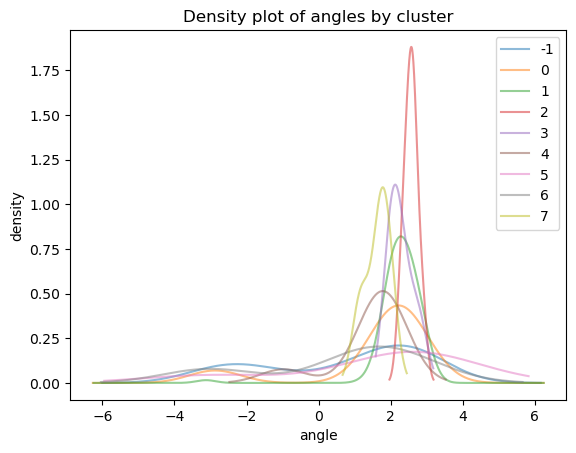

In [17]:
df_ang = utils.get_angles(df, -1)
df_ang['label'] = pos_labels
# density by label 
df_ang.groupby('label').angle.plot(kind='kde', legend=True, alpha=0.5)
plt.xlabel('angle')
plt.ylabel('density')
plt.title('Density plot of angles by cluster')
plt.show()

<AxesSubplot:>

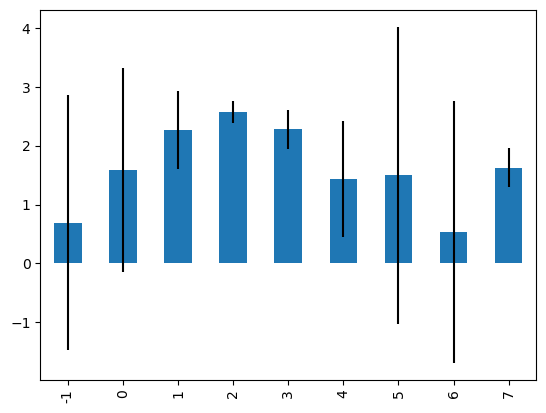

In [18]:
df_ang = utils.get_angles(df, -1)
err = df_ang.groupby(pos_labels).angle.std()
df_ang.groupby(pos_labels).angle.mean().plot(kind='bar', yerr=err)

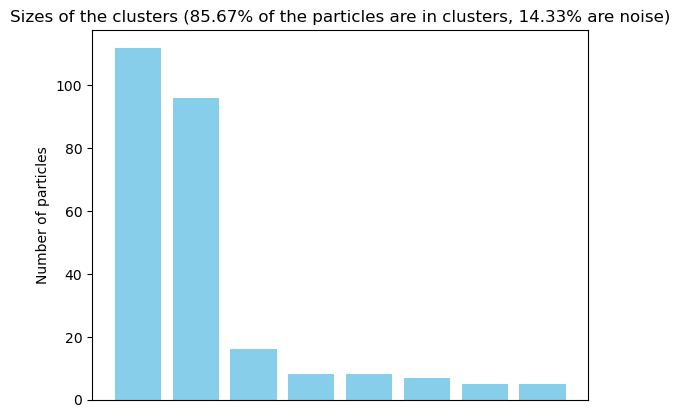

In [19]:
n_cl, n_noise = utils.clustering_labels_stats(pos_labels)
percent_cl, percent_noise = (N - n_noise)/N, n_noise/N 
cluster_counts = pd.DataFrame(pos_labels, columns=["etiquette"]) \
    .where(pd.DataFrame(pos_labels, columns=["etiquette"])["etiquette"] != -1).value_counts().to_numpy()
plt.bar(range(len(cluster_counts)), cluster_counts, color='skyblue')
plt.title(f"Sizes of the clusters ({percent_cl* 100:.2f}% of the particles are in clusters, {percent_noise* 100:.2f}% are noise)")
plt.ylabel("Number of particles")
plt.xticks([])
plt.show()

In [20]:
n_cl, n_noise = utils.clustering_labels_stats(pos_labels)
print(f"Number of clusters: {n_cl}, number of noise points: {n_noise}")
print(f'Particles in clusters: {N-n_noise}, noise particles: {n_noise}')
print(f'Percentage of particles in clusters: {(N-n_noise)/N*100:.2f}%')
print(f'Percentage of noise particles: {n_noise/N*100:.2f}%')

Number of clusters: 8, number of noise points: 43
Particles in clusters: 257, noise particles: 43
Percentage of particles in clusters: 85.67%
Percentage of noise particles: 14.33%


The best one is with **position only** !  

## Clustering with unscaled data and with periodic boundaries 

### Example : heatmap of the distance matrix between particles

In [21]:
# Point to compare
point = np.array([10, 10])
periods = np.array([50, 50])
X, Y = np.arange(50), np.arange(50)

In [22]:
# Distance matrix with periodic boundary conditions
Zper = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        point2 = np.array([X[i], Y[j]])
        # print(point2)
        Zper[i,j] = utils.distance_periodic(X = point, Y = point2, periods=periods)

In [23]:
Xmes, Ymesh = np.meshgrid(X, Y)
Z = np.sqrt((Xmes - point[0])**2 + (Ymesh - point[1])**2)

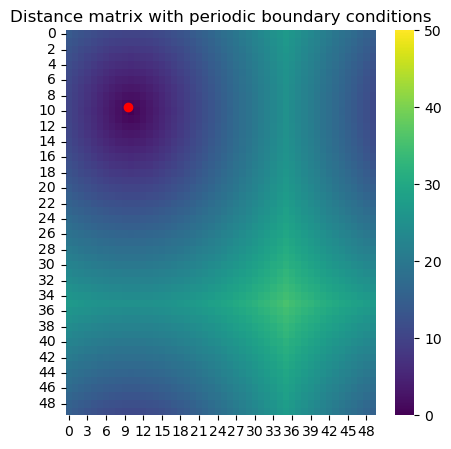

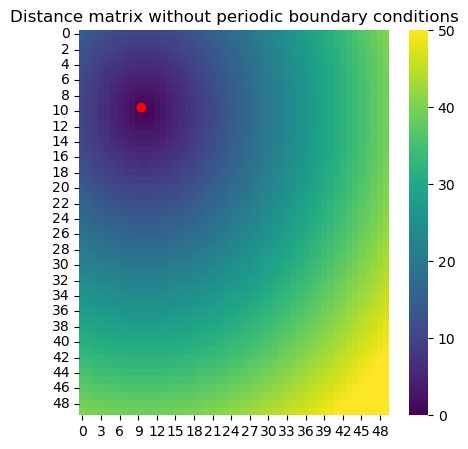

In [24]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(Zper, cmap='viridis', vmin=0, vmax=50)
ax.scatter(point[0], point[1], color='red')
plt.title('Distance matrix with periodic boundary conditions')
plt.show()

plt.figure(figsize=(5,5))
ax = sns.heatmap(Z, cmap='viridis', vmin=0, vmax=50)
ax.scatter(point[0], point[1], color='red') 
plt.title('Distance matrix without periodic boundary conditions')
plt.show()

### Clustering with DBSCAN - algorithm with periodic conditions

In [25]:
frame = 930
pos_per_labels = utils.periodic_clustering_labels_positions(df, frame, k_coef=1.8, L=L, min_samples=5)


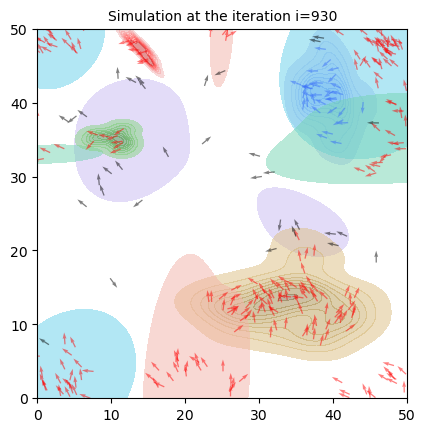

In [26]:

# With periodic boundary conditions
fig, ax = visualisation.plot_clusters(df, frame, pos_per_labels)


In [27]:
# Without periodic boundary conditions
pos_labels = clustering_labels_positions(df, frame, k_coef=1.8, rho=N/(L**2), min_samples=5)


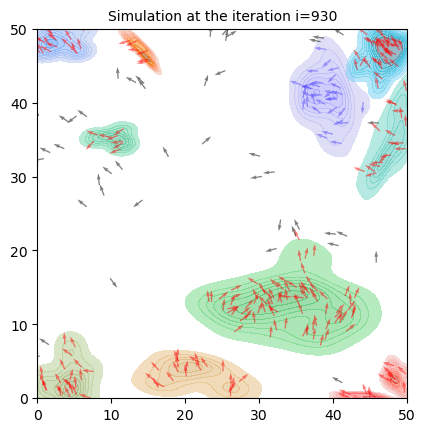

In [28]:

fig, ax = visualisation.plot_clusters(df, frame, pos_labels)
# plt.show()

## Statistics of clusters - Behaviour of clusters

### Average direction / position of flock 

In [29]:
i = 930

In [30]:
pos_per_labels = utils.periodic_clustering_labels_positions(df, i, k_coef=1.8, L=L, min_samples=5)

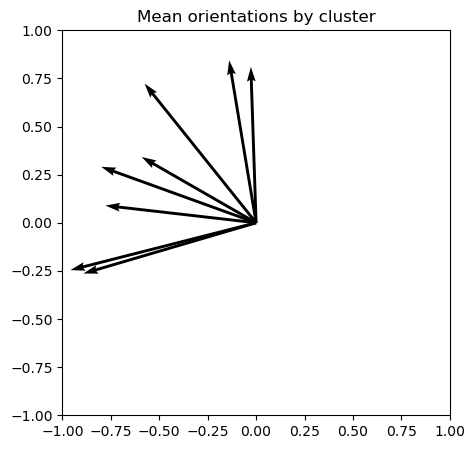

In [31]:
i = 930
df_orientation = utils.get_orientations(df, i)
df_orientation['cluster'] = pos_per_labels
# mean of the orientations by cluster
gb = df_orientation.groupby('cluster').mean()
# plot in polar coordinates
plt.figure(figsize=(5,5))
plt.quiver(np.zeros(len(gb)), np.zeros(len(gb)), gb.theta_x, gb.theta_y, angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Mean orientations by cluster')
plt.show()

In [32]:
def get_centroids(df, labels, noiseBool = False):
    df = df.copy()
    df['labels'] = labels
    if not noiseBool:
        df = df[df['labels'] != -1]
    return df.groupby('labels').mean()

df_pos = utils.get_positions(df, 930)
gb = get_centroids(df_pos, pos_per_labels)
gb


,x,y
labels,,
0,39.212855,40.742634
1,27.648610,29.286233
2,37.779640,34.793968
3,10.298261,35.103323
4,33.986183,12.512782
5,21.822249,10.364701
6,14.081456,47.059857


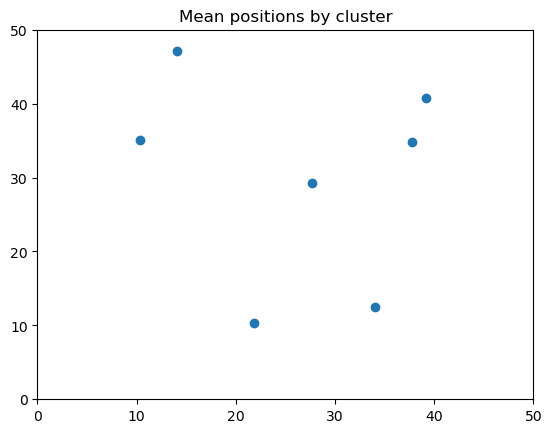

In [33]:

plt.scatter(gb.x, gb.y)
plt.xlim(0, L)
plt.ylim(0, L)
plt.title('Mean positions by cluster')
plt.show()


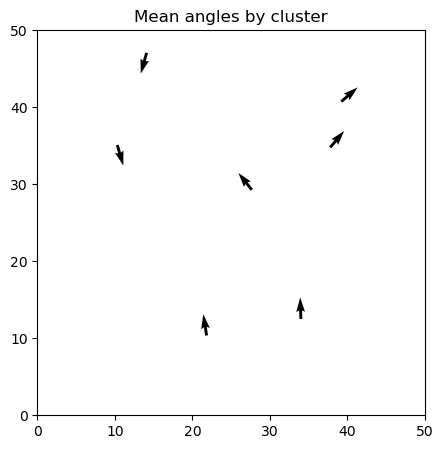

In [34]:
df_ang = utils.get_positions_and_angles(df, i)
gb = get_centroids(df_ang, pos_per_labels)

plt.figure(figsize=(5,5))
plt.quiver(gb.x, gb.y, np.cos(gb.angle), np.sin(gb.angle))
plt.xlim(0, L)
plt.ylim(0, L)
plt.title('Mean angles by cluster')
plt.show()

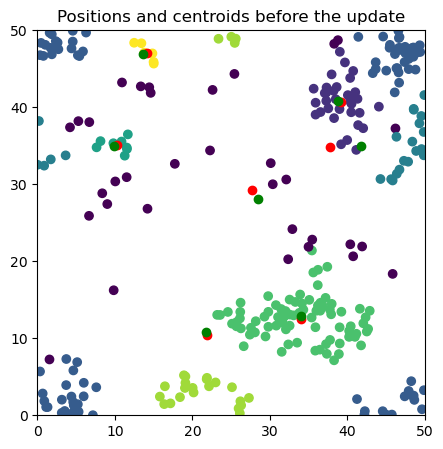

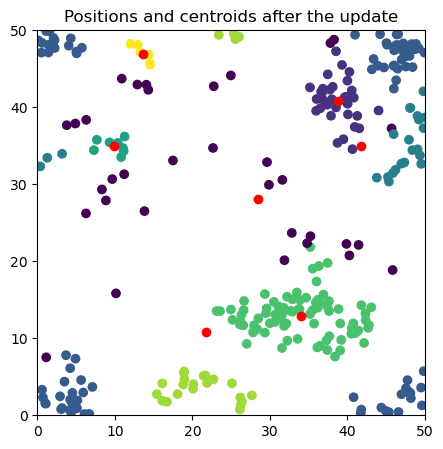

In [35]:
df_pos_before = utils.get_positions(df, i)
gb_centroids_before = get_centroids(df_pos, pos_per_labels)

df_pos_after = utils.get_positions(df, i+1)
gb_centroids_after = get_centroids(df_pos_after, pos_per_labels)

plt.figure(figsize=(5,5))
plt.scatter(df_pos_before.x, df_pos_before.y, c=pos_per_labels)
plt.scatter(gb_centroids_before.x, gb_centroids_before.y, c='red')
plt.scatter(gb_centroids_after.x, gb_centroids_after.y, c='green')
plt.xlim(0, L)
plt.ylim(0, L)
plt.title('Positions and centroids before the update')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(df_pos_after.x, df_pos_after.y, c=pos_per_labels)
plt.scatter(gb_centroids_after.x, gb_centroids_after.y, c='red')
plt.xlim(0, L)
plt.ylim(0, L)
plt.title('Positions and centroids after the update')
plt.show()

In [36]:

def centroid_distance_matrix(labels_before, labels_after, df_pos_before, df_pos_after, L = L): 
    # Creating centroids 
    gb_centroids_before = get_centroids(df_pos_before, labels_before)
    gb_centroids_after = get_centroids(df_pos_after, labels_after)

    dist = np.zeros((len(gb_centroids_before), len(gb_centroids_after)))
    labels_before = gb_centroids_before.index
    labels_after = gb_centroids_after.index
    for i in range(len(gb_centroids_before)):
        for j in range(len(gb_centroids_after)):
            x_i, y_i = gb_centroids_before.iloc[i].x, gb_centroids_before.iloc[i].y
            x_j, y_j = gb_centroids_after.iloc[j].x, gb_centroids_after.iloc[j].y
            dist[i,j] = utils.distance_periodic(np.array([x_i, y_i]), np.array([x_j, y_j]), np.array([L, L]))

    return dist, labels_before, labels_after

pos_per_labels = utils.periodic_clustering_labels_positions(df, i, k_coef=1.8, L=L, min_samples=5)
labels_before = pos_per_labels
print(utils.clustering_labels_stats(labels_before))
pos_per_labels = utils.periodic_clustering_labels_positions(df, i+1, k_coef=1.8, L=L, min_samples=5)
labels_after = pos_per_labels
print(utils.clustering_labels_stats(labels_after))
df_pos_before = utils.get_positions(df, i)
df_pos_after = utils.get_positions(df, i+1)

dist, labels_before, labels_after = centroid_distance_matrix(labels_before, labels_after, df_pos_before, df_pos_after)
dist.shape

(7, 33)
(8, 31)


(7, 8)

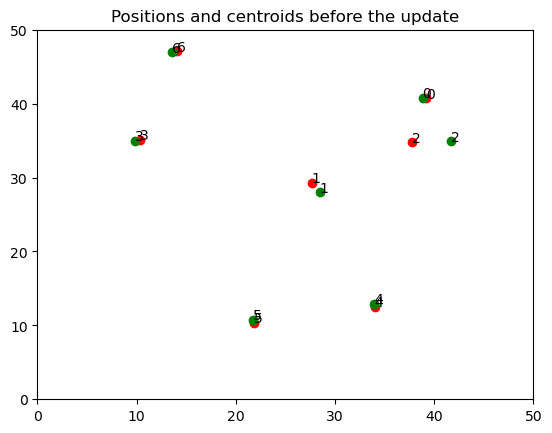

In [37]:

fig, ax = plt.subplots()
ax.scatter(gb_centroids_before.x, gb_centroids_before.y, c='red')
ax.scatter(gb_centroids_after.x, gb_centroids_after.y, c='green')
# annotate with label 
for i, txt in enumerate(gb_centroids_before.index):
    ax.annotate(txt, (gb_centroids_before.x.iloc[i], gb_centroids_before.y.iloc[i]))
for i, txt in enumerate(gb_centroids_after.index):
    ax.annotate(txt, (gb_centroids_after.x.iloc[i], gb_centroids_after.y.iloc[i]))
# for i in range(len(gb_centroids_before)):
#     for j in range(len(gb_centroids_after)):
#         x_i, y_i = gb_centroids_before.iloc[i].x, gb_centroids_before.iloc[i].y
#         x_j, y_j = gb_centroids_after.iloc[j].x, gb_centroids_after.iloc[j].y
#         ax.plot([x_i, x_j], [y_i, y_j], c='black', alpha=0.5)
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_title('Positions and centroids before the update')
plt.show()